Files already downloaded and verified
Files already downloaded and verified
tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

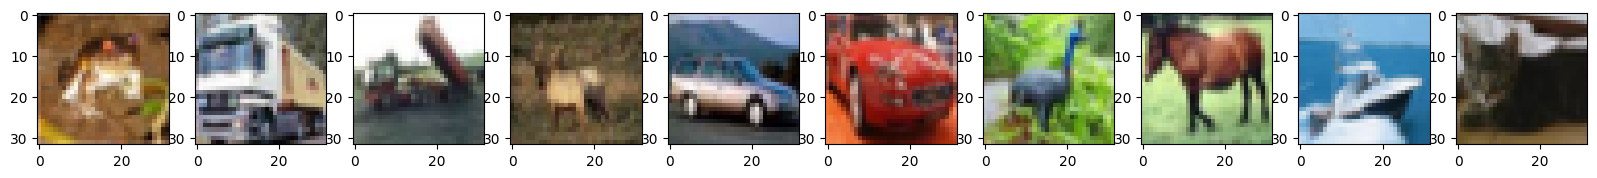

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets
from torchvision.models import resnet18

CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

len(y_train), len(y_test)

X_train.min(), X_train.max()

X_train /= 255.
X_test /= 255.

CIFAR_train.classes

import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

X_train.shape, y_train.shape

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

X_train.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(net, X_train, y_train, X_test, y_test, wetght_decay_flag):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    if wetght_decay_flag:
      optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=1e-4)

    batch_size = 70

    test_accuracy_history = []
    test_loss_history = []
    train_accuracy_history = []
    train_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        with torch.no_grad():
          test_preds = net.forward(X_test)
          test_loss_history.append(loss(test_preds, y_test).data.cpu())

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
          test_accuracy_history.append(accuracy)

          train_preds = net.forward(X_train)
          train_loss_history.append(loss(train_preds, y_train).data.cpu())

          accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().data.cpu()
          train_accuracy_history.append(accuracy)

          print(f'Эпоха №{epoch + 1}, точность на тестовых данных: {test_accuracy_history[-1]}, точность на тренеровочных данных: {train_accuracy_history[-1]}')
    print('---------------')
    return test_accuracy_history, test_loss_history, train_accuracy_history, train_loss_history

accuracies_test = {}
losses_test = {}
accuracies_train = {}
losses_train = {}

In [ ]:
import torch

class BasicBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.act1 = torch.nn.ReLU(inplace=True)

        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity
        x = self.act1(x)
        return x


class ResNet20(torch.nn.Module):
    def __init__(self):
        super(ResNet20, self).__init__()
        self.in_channels = 16  # Начальное количество каналов

        self.conv1 = torch.nn.Conv2d(3, self.in_channels, kernel_size=3, padding=1, bias=False)   # Результат: 32x32x16
        self.bn1 = torch.nn.BatchNorm2d(self.in_channels)
        self.act1 = torch.nn.ReLU(inplace=True)

        # Стек блоков ResNet
        self.layer1 = self._make_layer(BasicBlock, self.in_channels, 3)   # 16 каналов
        self.layer2 = self._make_layer(BasicBlock, 32, 3, stride=2)    # Увеличиваем количество до 32
        self.layer3 = self._make_layer(BasicBlock, 64, 3, stride=2)    # Увеличиваем количество до 64

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Адаптивный пулинг до 1x1
        self.fc = torch.nn.Linear(64, 10)  # 10 классов для CIFAR10

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



In [ ]:
accuracies_test['ResNet20'], losses_test['ResNet20'], accuracies_train['ResNet20'], losses_train['ResNet20'] = \
    train(ResNet20(), X_train, y_train, X_test, y_test, false)

Эпоха №1, точность на тестовых данных: 0.5722999572753906, точность на тренеровочных данных: 0.5876399874687195
Эпоха №2, точность на тестовых данных: 0.6040999889373779, точность на тренеровочных данных: 0.6251400113105774
Эпоха №3, точность на тестовых данных: 0.7238999605178833, точность на тренеровочных данных: 0.7540799975395203
Эпоха №4, точность на тестовых данных: 0.7623999714851379, точность на тренеровочных данных: 0.7980200052261353
Эпоха №5, точность на тестовых данных: 0.7013999819755554, точность на тренеровочных данных: 0.7461599707603455
Эпоха №6, точность на тестовых данных: 0.7508999705314636, точность на тренеровочных данных: 0.806939959526062
Эпоха №7, точность на тестовых данных: 0.7917999625205994, точность на тренеровочных данных: 0.8668999671936035
Эпоха №8, точность на тестовых данных: 0.801099956035614, точность на тренеровочных данных: 0.8830199837684631
Эпоха №9, точность на тестовых данных: 0.7911999821662903, точность на тренеровочных данных: 0.87241995334

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

def save_data_to_file(data_dict, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data_dict, file)

save_data_to_file(accuracies_test, '/content/drive/MyDrive/Colab Notebooks/accuracies_test.pkl')
save_data_to_file(losses_test, '/content/drive/MyDrive/Colab Notebooks/losses_test.pkl')
save_data_to_file(accuracies_train, '/content/drive/MyDrive/Colab Notebooks/accuracies_train.pkl')
save_data_to_file(losses_train, '/content/drive/MyDrive/Colab Notebooks/losses_train.pkl')

In [ ]:
import pickle

def load_data_from_file(filename):
    with open(filename, 'rb') as file:
        data_dict = pickle.load(file)
    return data_dict

accuracies_test_resnet20 = load_data_from_file('/content/drive/MyDrive/Colab Notebooks/accuracies_test_1_200.pkl')
losses_test_resnet20 = load_data_from_file('/content/drive/MyDrive/Colab Notebooks/losses_test_1_200.pkl')
accuracies_train_resnet20 = load_data_from_file('/content/drive/MyDrive/Colab Notebooks/accuracies_train_1_200.pkl')
losses_train_resnet20 = load_data_from_file('/content/drive/MyDrive/Colab Notebooks/losses_train_1_200.pkl')

accuracies_test_resnet20_r = load_data_from_file('/content/drive/MyDrive/Colab Notebooks/accuracies_test_3_200.pkl')
losses_test_resnet20_r = load_data_from_file('/content/drive/MyDrive/Colab Notebooks/losses_test_3_200.pkl')
accuracies_train_resnet20_r = load_data_from_file('/content/drive/MyDrive/Colab Notebooks/accuracies_train_3_200.pkl')
losses_train_resnet20_r = load_data_from_file('/content/drive/MyDrive/Colab Notebooks/losses_train_3_200.pkl')

СРАВНЕНИЕ РЕЗУЛЬТАТОВ НЕЙРОННЫХ СЕТЕЙ

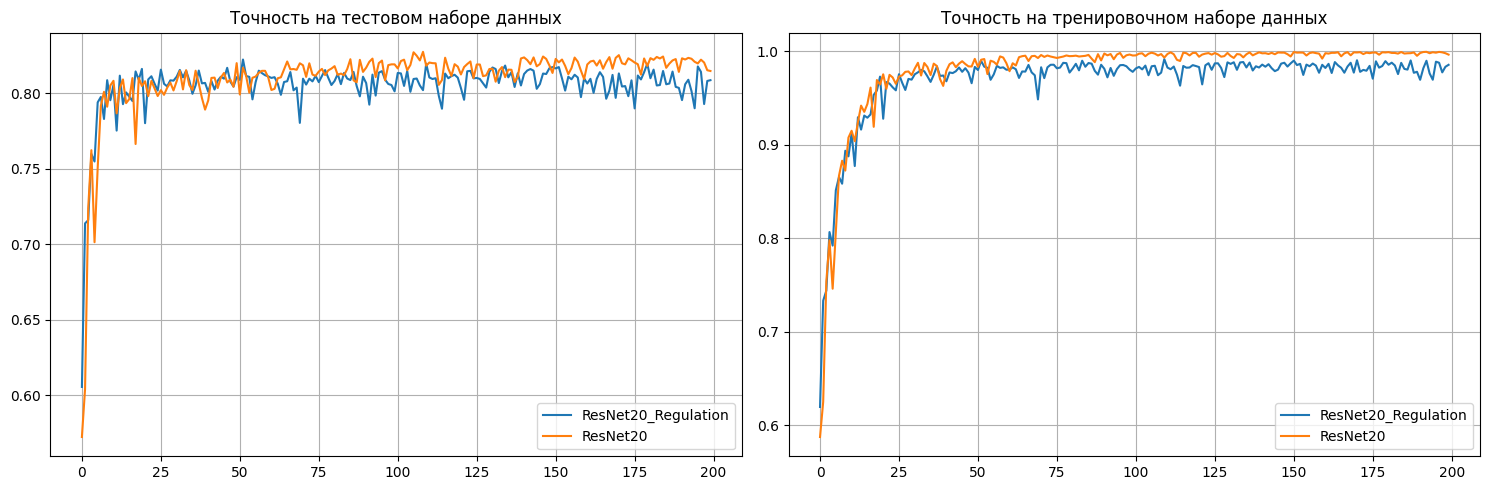

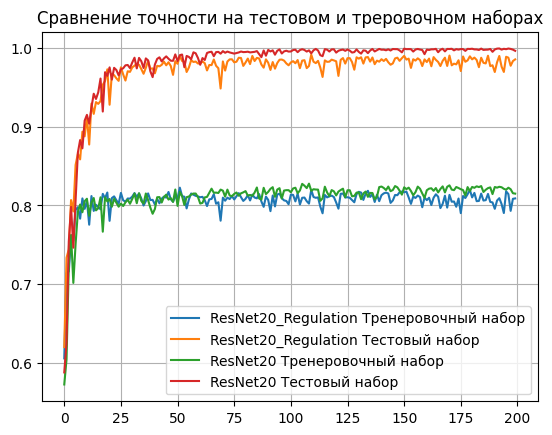

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Точность на тестовом наборе данных')
for experiment_id in accuracies_test_resnet20_r.keys():
    axes[0].plot(accuracies_test_resnet20_r[experiment_id], label=experiment_id)
for experiment_id in accuracies_test_resnet20.keys():
    axes[0].plot(accuracies_test_resnet20[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Точность на тренировочном наборе данных')
for experiment_id in accuracies_train_resnet20_r.keys():
    axes[1].plot(accuracies_train_resnet20_r[experiment_id], label=experiment_id)
for experiment_id in accuracies_train_resnet20.keys():
    axes[1].plot(accuracies_train_resnet20[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение точности на тестовом и треровочном наборах')
plt.plot(accuracies_test_resnet20_r["ResNet20_Regulation"], label="ResNet20_Regulation Тренеровочный набор")
plt.plot(accuracies_train_resnet20_r["ResNet20_Regulation"], label="ResNet20_Regulation Тестовый набор")
plt.plot(accuracies_test_resnet20["ResNet20"], label="ResNet20 Тренеровочный набор")
plt.plot(accuracies_train_resnet20["ResNet20"], label="ResNet20 Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()

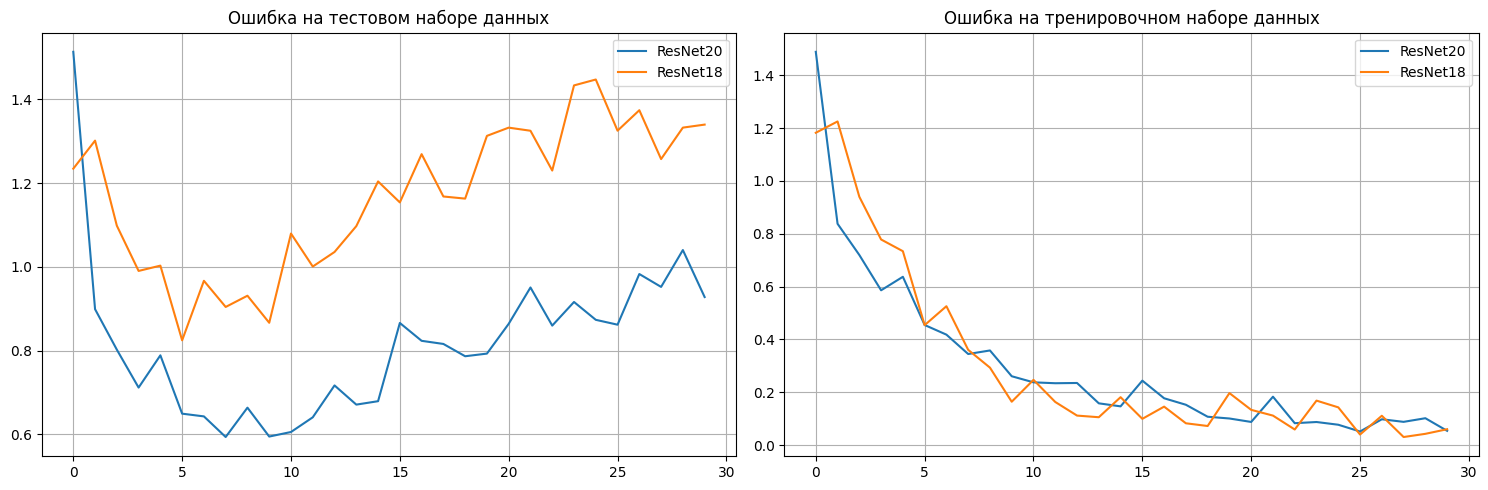

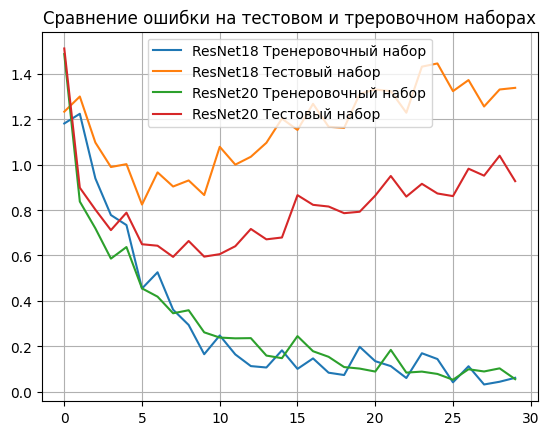

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Ошибка на тестовом наборе данных')
for experiment_id in losses_test.keys():
    axes[0].plot(losses_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Ошибка на тренировочном наборе данных')
for experiment_id in losses_train.keys():
    axes[1].plot(losses_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение ошибки на тестовом и треровочном наборах')
plt.plot(losses_train["ResNet18"], label="ResNet18 Тренеровочный набор")
plt.plot(losses_test["ResNet18"], label="ResNet18 Тестовый набор")
plt.plot(losses_train["ResNet20"], label="ResNet20 Тренеровочный набор")
plt.plot(losses_test["ResNet20"], label="ResNet20 Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()